In [34]:
import pandas as pd
import os
os.chdir('/home/tm_ba/Desktop/Bachelorarbeit_code')


In [35]:
# Modify MotionDataset to use positions instead of speeds
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
class MotionDataset(Dataset):
    def __init__(self, data, seq_length=50):
        """
        Args:
            data (DataFrame): DataFrame containing joint positions for each frame.
            seq_length (int): Length of sequences to use for LSTM.
        """
        self.data = data
        self.seq_length = seq_length
        self.num_samples = data.shape[0] - seq_length

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        # Extract sequences of joint positions
        x = self.data.iloc[idx:idx + self.seq_length].drop("Recording", axis=1).values
        # Predict the next sequence of joint positions
        y = self.data.iloc[idx + 1:idx + self.seq_length + 1].drop("Recording", axis=1).values
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)




In [36]:
processed_data = pd.read_csv("csv_new/processed_Trajectories.csv")

In [37]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Assuming `processed_data` is your DataFrame that contains the joint positions and 'Recording' column
recordings = processed_data['Recording'].unique()  # Get unique recordings
recordings.sort()  # Sort the recordings

# Split recordings into 70% training and 30% testing
train_recordings = recordings[:int(0.7 * len(recordings))]
test_recordings = recordings[int(0.7 * len(recordings)):]

# Create train and test sets based on the recordings
train_set = processed_data[processed_data['Recording'].isin(train_recordings)]
test_set = processed_data[processed_data['Recording'].isin(test_recordings)]

# Display the shapes to verify the split
print(f'Training set size: {train_set.shape}')
print(f'Test set size: {test_set.shape}')

Training set size: (20067, 24)
Test set size: (8973, 24)


In [38]:
# Create training and test datasets
train_dataset = MotionDataset(train_set, seq_length=1)
test_dataset = MotionDataset(test_set, seq_length=1)

# Create DataLoaders for training and testing
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Training loop can remain the same, but now it trains on `train_dataloader`
# Evaluation should use `test_dataloader`


In [22]:
class MotionLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(MotionLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(num_layers, x.size(0), hidden_size).to(x.device)
        c0 = torch.zeros(num_layers, x.size(0), hidden_size).to(x.device)

        out, _ = self.lstm(x, (h0, c0))  # Passing through LSTM
        out = self.fc(out)  # Fully connected layer to map to output size
        return out

# Model hyperparameters
input_size = len(processed_data.columns) - 1  # Number of joints (without 'Recording' column)
hidden_size = 128  # You can adjust this value
num_layers = 2
output_size = input_size  # Same as input size (number of joints)

model = MotionLSTM(input_size, hidden_size, num_layers, output_size)


Epoch [1/20], Loss: 88359.7527
Epoch [2/20], Loss: 50462.1603
Epoch [3/20], Loss: 28664.2420
Epoch [4/20], Loss: 16677.9108
Epoch [5/20], Loss: 10764.9261
Epoch [6/20], Loss: 8326.0447
Epoch [7/20], Loss: 7534.2286
Epoch [8/20], Loss: 7339.8507
Epoch [9/20], Loss: 7307.7306
Epoch [10/20], Loss: 7305.4878
Epoch [11/20], Loss: 7305.3514
Epoch [12/20], Loss: 7305.5882
Epoch [13/20], Loss: 7305.1626
Epoch [14/20], Loss: 7305.2270
Epoch [15/20], Loss: 7305.4297
Epoch [16/20], Loss: 7305.3707
Epoch [17/20], Loss: 7305.4000
Epoch [18/20], Loss: 7305.1452
Epoch [19/20], Loss: 7305.3119
Epoch [20/20], Loss: 7305.3273


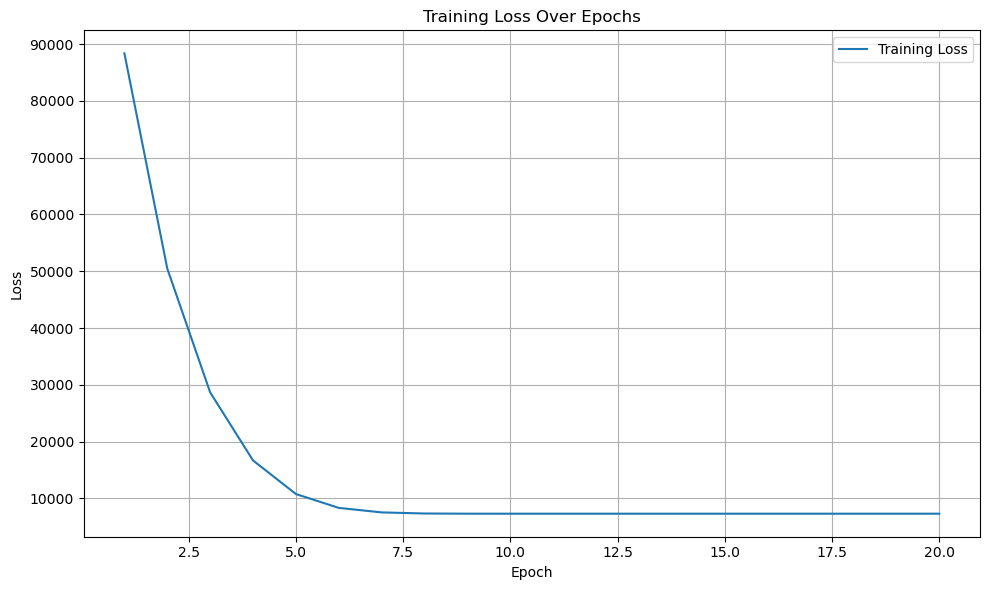

In [23]:
import torch
import matplotlib.pyplot as plt

# Training setup
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model.train()

# List to store loss values per epoch
epoch_losses = []

# Training loop
num_epochs = 20  # Adjust the number of epochs as needed

for epoch in range(num_epochs):
    running_loss = 0.0  # For collecting the average loss per epoch
    batch_count = 0
    
    for i, (inputs, targets) in enumerate(train_dataloader):
        # Move tensors to the appropriate device (GPU if available)
        if torch.cuda.is_available():
            model.cuda()
            inputs = inputs.cuda() 
            targets = targets.cuda()
        
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Accumulate loss
        running_loss += loss.item()
        batch_count += 1

    # Calculate average loss for the epoch
    epoch_loss = running_loss / batch_count
    epoch_losses.append(epoch_loss)

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}')

# Save the model after training
torch.save(model.state_dict(), 'motion_lstm.pth')



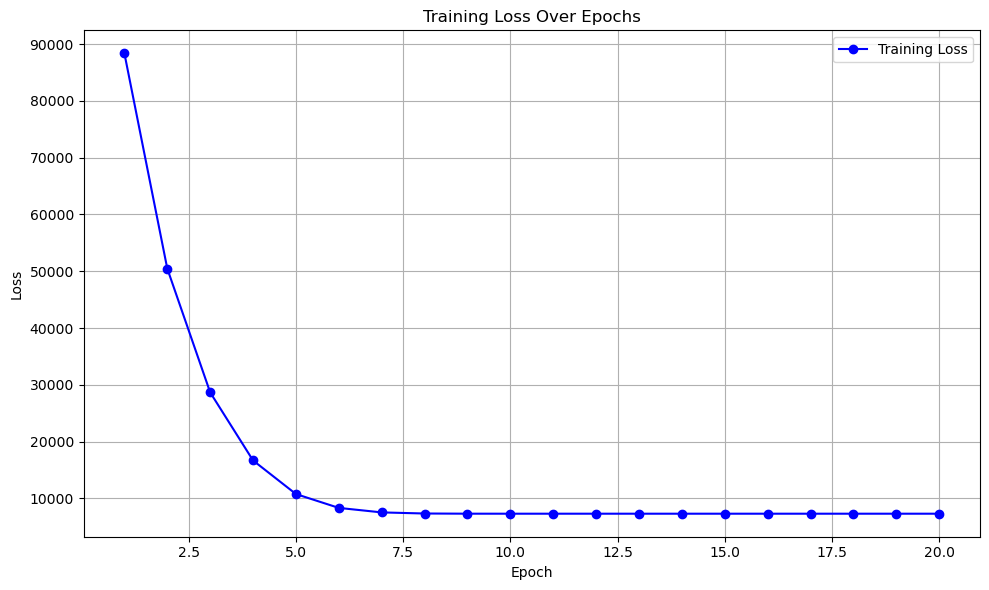

In [24]:
import matplotlib.pyplot as plt

# After training, plot the loss over epochs
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), epoch_losses, label='Training Loss', color='b', linestyle='-', marker='o')

# Add title and labels
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')

# Display the legend and grid
plt.legend()
plt.grid(True)

# Adjust layout for better visualization
plt.tight_layout()

# Show the plot
plt.show()


In [39]:
for input, target in test_dataloader:
    print(input.shape, target)
    break

torch.Size([32, 1, 23]) tensor([[[  3.0000,   0.0000, 436.5380,  33.8315, 639.2493, 481.0810,  58.8537,
          439.9550, 454.5810, 109.6750, 302.0805, 384.9710, 213.7530,  73.4582,
          432.6840, 154.4810, 178.3995, 514.5287, 246.5839,  76.5910, 305.6510,
          289.2940,  17.5622]],

        [[  4.0000,   0.0000, 436.2880,  33.9517, 639.6100, 481.2590,  58.5006,
          440.2480, 454.9820, 108.9420, 302.5630, 384.9540, 213.9360,  75.1434,
          432.5540, 154.4130, 179.3290, 504.4315, 246.0079,  76.9100, 304.6920,
          289.2210,  18.6682]],

        [[  5.0000,   0.0000, 436.0010,  34.0639, 639.8710, 481.4310,  58.0753,
          440.6770, 455.4690, 108.4350, 302.8430, 384.4060, 214.1890,  76.8287,
          432.4290, 154.2270, 179.9720, 494.3344, 245.4318,  77.2290, 303.1620,
          288.7510,  20.4648]],

        [[  6.0000,   0.0000, 435.7170,  34.1892, 640.1175, 481.6710,  57.7714,
          441.1060, 456.0470, 108.0960, 303.1870, 383.4190, 214.2290,  77.378